In [1]:
%matplotlib inline
%load_ext autoreload
#%load_ext lab_black

In [2]:
from traffic.data.datasets import landing_zurich_2019 as t

/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:294: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance(name, collections.Sequence):


In [3]:
stats = t.groupby("flight_id").agg({"runway": "max", "initial_flow": "max"})
stats = stats.reset_index().groupby(["runway", "initial_flow"]).count().unstack()
stats

flight_id                                 
initial_flow   162-216 24-72 240-276 312-354 90-132 N/A
runway                                                 
14                4437  2048    3437    1307   3170  58
16                   1     1       1       1      4   1
28                 899   567     678     323    668  31
34                 340   182     586     118    366   6
N/A                 76    24      91      31     22   6

In [4]:
# 1 flux
from traffic.core import Traffic
t_f = t.query("initial_flow == '162-216' and runway =='14'").resample(30).unwrap("track").eval(max_workers=10)
t_f.to_pickle("lszh.pkl")
t_f.data.head()

,timestamp,altitude,callsign,geoaltitude,groundspeed,icao24,lastseen,latitude,longitude,onground,origin,track,vertical_rate,distance,flight_id,runway,initial_bearing,initial_flow,simple,track_unwrapped
0,2019-10-02 11:30:46+00:00,14375.0,DLH8NJ,14475.0,363.005196,3c66a4,2019-10-02 11:47:50+00:00,48.127396,8.495453,False,EDDF,175.577089,-1408.0,39.843451,DLH8NJ_1976,14,176.850937,162-216,True,175.577089
1,2019-10-02 11:31:07+00:00,13775.0,DLH8NJ,13900.0,357.525914,3c66a4,2019-10-02 11:47:50+00:00,48.092926,8.494698,False,EDDF,185.295991,-1792.0,37.778987,DLH8NJ_1976,14,176.850937,162-216,True,185.295991
2,2019-10-02 11:31:29+00:00,13150.0,DLH8NJ,13250.0,349.044108,3c66a4,2019-10-02 11:47:50+00:00,48.056992,8.488174,False,EDDF,187.572949,-1408.0,35.642789,DLH8NJ_1976,14,176.850937,162-216,True,187.572949
3,2019-10-02 11:31:50+00:00,12575.0,DLH8NJ,12650.0,342.708035,3c66a4,2019-10-02 11:47:50+00:00,48.024592,8.481797,False,EDDF,187.207963,-2112.0,33.722474,DLH8NJ_1976,14,176.850937,162-216,True,187.207963
4,2019-10-02 11:32:12+00:00,11800.0,DLH8NJ,11900.0,341.715961,3c66a4,2019-10-02 11:47:50+00:00,47.990067,8.475471,False,EDDF,187.229001,-1984.0,31.680064,DLH8NJ_1976,14,176.850937,162-216,True,187.229001


In [2]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

from traffic.core import Traffic
from traffic.drawing import Lambert93

from artefact import AutoencoderTSNE, Autoencoder

t = Traffic.from_file("lszh.pkl")
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]

nb_flights = len(t)
nb_samples = len(t[0])
nb_features = len(list_features)
print(f"nb_flights: {len(t)}")

!rm -rf lightning_logs/
!rm -rf checkpoints/

algo_clustering = AutoencoderTSNE(
    gpus=[0,1,2],
    batch_size=100,
    model=Autoencoder((nb_samples*nb_features, 32, 8, 2)),
    lambda_kl=0.05,
    epochs=100,
    algo_clustering=DBSCAN(eps=0.06, min_samples=20),
    distance_trajectory="euclidean",  # delta_max
)

t_tsne = t.clustering(
    nb_samples=None,
    #projection=Lambert93(),
    features=list_features,
    clustering=algo_clustering,
    transform=MinMaxScaler(feature_range=(-1, 1)),
).fit_predict()

model = algo_clustering.model

t_tsne.to_pickle("t_tsne.pkl")
t_tsne.groupby(["cluster"]).agg({"flight_id": "nunique"})

nb_flights: 4437


INFO:artefact.clustering:Start training...
INFO:artefact.clustering:Loading model from checkpoints/_ckpt_epoch_1000.ckpt


,flight_id
cluster,
-1,557
0,3767
1,37
2,32
3,44


Text(0.5, 1.0, 'd_kl')

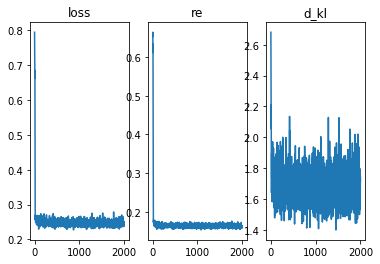

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

metrics = pd.read_csv('lightning_logs/version_0/metrics.csv')

plt.figure(1)
plt.subplot(131)
plt.plot(metrics.loss)
plt.title("loss")

plt.subplot(132)
plt.plot(metrics.re)
plt.title("re")

plt.subplot(133)
plt.plot(metrics.kl)
plt.title("d_kl")


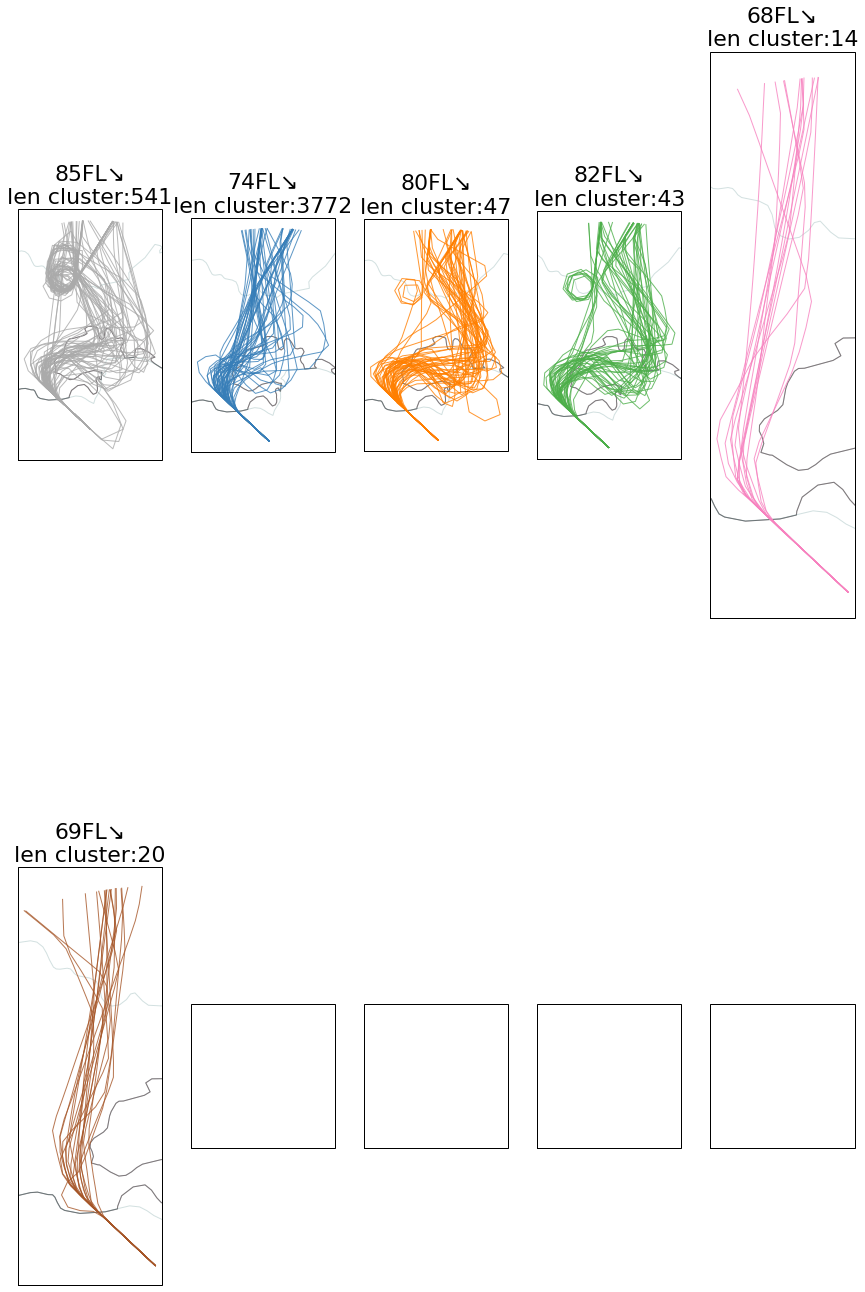

In [15]:
from traffic.core import Traffic
from artefact.plot import plot_trajs

t_tsne = Traffic.from_file("t_tsne.pkl")
plot_trajs(t_tsne, None)
